In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import xavierUtils as xu
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import matplotlib.colors as colors 
from matplotlib.patches import Patch
import datetime as dt
%autosave 1000000

Autosaving every 1000000 seconds


### Funções

In [2]:
def fracColorF(now, mean, dev):
    if now>mean+dev:
        return 'darkturquoise'
    if now<mean+dev and now>mean-dev:
        return 'y'
    if now<mean-dev:
        return 'orangered'

In [3]:
def repeatEntryQ(series):
    u = series.unique()
    if len(series) > len(u):
        return True
    elif len(series) == len(u):
        return False
    else:
        raise Exception('len(unique) > sum(unique): shouldn\'t happen')

### Carrega dados

In [4]:
query = 'SELECT * FROM `gabinete-compartilhado.camara_v2.proposicoes_temas`'

raw = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../../keys-configs/gabinete-compartilhado.json')

In [5]:
r=raw.reset_index(drop=True)

In [6]:
r['id'] = r.uriProposicao.apply(lambda s: int(s.split('/')[-1]))

### Exploração

In [10]:
xu.unique(r.columns)

10: ano | api_url | capture_date | codTema | id | numero | relevancia | siglaTipo | tema | uriProposicao


In [11]:
xu.checkMissing(r)

Colunas com valores faltantes:
         coluna       N      %
1       api_url  133896  98.69
2  capture_date  133896  98.69


In [12]:
xu.mapUnique(r)


ano: 32 unique values.
(sample) 1989,  1991,  1992,  1993,  1994,  1995,  1996,  1998,  2002,  2003,  2005,  2006,  2007,  2008,  2009,  2012,  2013,  2014,  2015,  2016

api_url: 2 unique values.
None,  https://dadosabertos.camara.leg.br/arquivos/proposicoesTemas/json/proposicoesTemas-2019.json

capture_date: 2 unique values.
None,  2019-03-29 12:00:46

codTema: 30 unique values.
(sample) 39,  40,  41,  42,  43,  48,  52,  53,  54,  55,  56,  57,  58,  60,  61,  67,  68,  70,  72,  74

numero: 11278 unique values.
(sample) 263,  370,  982,  1608,  2607,  2885,  2900,  3037,  3867,  4853,  5127,  5309,  5761,  7387,  7867,  8167,  8169,  8292,  10411,  10977

relevancia: 8 unique values.
0,  1,  2,  3,  4,  5,  6,  7

siglaTipo: 26 unique values.
(sample) CON,  DCR,  EMS,  INA,  INC,  MSC,  MTC,  PDC,  PDL,  PFC,  PL,  PLV,  PRC,  PRN,  R.C,  RCP,  REP,  RIC,  SUG,  TVR

tema: 30 unique values.
(sample) Agricultura, Pecuária, Pesca e Extrativismo,  Cidades e Desenvolvimento Urbano,  C

In [10]:
xu.one2oneQ(r,'codTema','tema')

True

### Verifica ocorrência de proposições no mesmo período

#### Carrega e verifica dados de proposições

In [7]:
query = "SELECT * FROM `gabinete-compartilhado.camara_v2.proposicoes`"

prop = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                   dialect='standard',
                   private_key='../../keys-configs/gabinete-compartilhado.json')

In [17]:
xu.columns(prop)

28: ano | api_url | capture_date | codTipo | codTipoAutor | dataApresentacao | descricaoTipo | ementa | ementaDetalhada | id | idDeputadoAutor | idProposicao | keywords | nomeAutor | numero | siglaPartidoAutor | siglaTipo | siglaUFAutor | statusProposicao | tipoAutor | uri | uriAutor | uriAutores | uriPartidoAutor | uriPropPosterior | uriPropPrincipal | uriProposicao | urlInteiroTeor


In [8]:
p = prop
# Esse cógigo estava aqui, mas a key 'ultimoStatus' aparentemente desapareceu!
#p = prop.reset_index(drop=True)
#p['dataStatus'] = p.ultimoStatus.map(lambda d: d['data'])

In [ ]:
xu.unique(p.columns)

In [ ]:
xu.checkMissing(p)

In [ ]:
xu.unique(p.columns)

In [ ]:
float(len(p.loc[(p.ano==pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano==p.dataStatus.dt.year)]))/len(p)

In [ ]:
float(len(p.loc[(p.ano!=pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano!=p.dataStatus.dt.year)]))/len(p)

In [ ]:
float(len(p.loc[(p.ano==pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano!=p.dataStatus.dt.year)]))/len(p)

In [ ]:
float(len(p.loc[(p.ano!=pd.to_datetime(p.dataApresentacao).dt.year)&(p.ano==p.dataStatus.dt.year)]))/len(p)

In [ ]:
# CONCLUSÃO: Na grande maioria dos casos, o ano das proposições é o ano de apresentação.

## Realiza a análise

In [9]:
temasData = r.join(p[['id','ano','dataApresentacao']].set_index('id').rename(axis='columns', 
                                                                             mapper={'ano':'anoProp'}), on='id')

In [10]:
def displaceDate(date):
    try:
        return date.replace(year=2019)
    except:
        return date.replace(day=28, year=2019)

In [11]:
temasData['dataDisplaced'] = pd.to_datetime(temasData.dataApresentacao).apply(displaceDate)

In [12]:
temasData.capture_date.unique()

array([None, u'2019-03-29 12:00:46'], dtype=object)

In [13]:
temasData.dataApresentacao.max()

u'2019-03-21T16:09:42'

In [31]:
dt.datetime.strptime('2019-02-01','%Y-%m-%d')-dt.datetime.strptime('2019-05-12','%Y-%m-%d')

datetime.timedelta(-100)

In [15]:
s = temasData.loc[(temasData.dataDisplaced>='2019-02-01') & (temasData.dataDisplaced<='2019-05-11')]
#s = temasData
#s = temasData.loc[(temasData.dataDisplaced<'2019-04-25') & (temasData.siglaTipo=='PL')]
#s = temasData.loc[(temasData.siglaTipo=='PL')]
#s = temasData.loc[(temasData.dataDisplaced<'2019-04-25') & (temasData.siglaTipo=='PEC')]

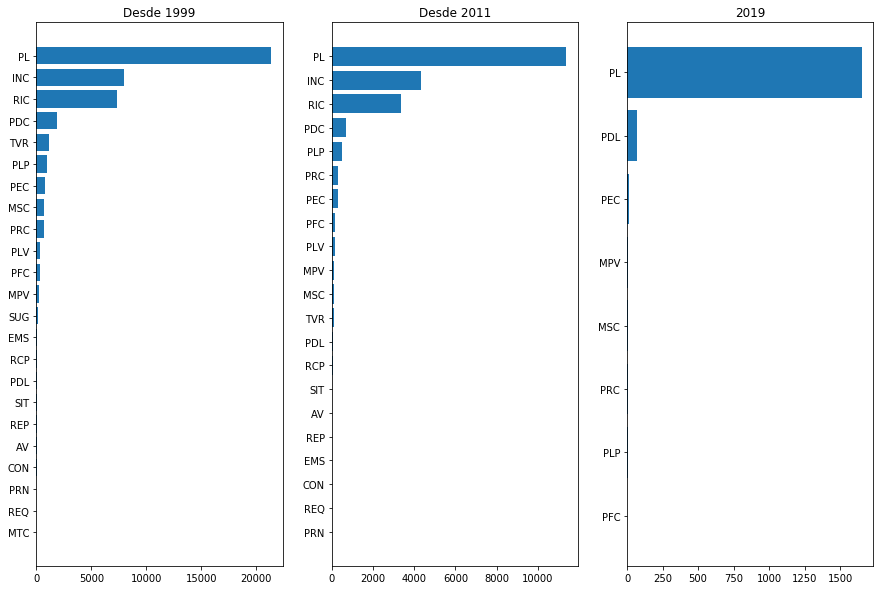

In [16]:
pl.figure(figsize=(15,10))

pl.subplot(1,3,1)
pl.title('Desde 1999')
nByTipo = s.loc[(s.ano>=1999)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.subplot(1,3,2)
pl.title('Desde 2011')
nByTipo = s.loc[(s.ano>=2011)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.subplot(1,3,3)
pl.title('2019')
nByTipo = s.loc[(s.ano>=2019)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values()
x = np.arange(1,1+len(nByTipo))
pl.yticks(x,nByTipo.index.values)
pl.barh(x,nByTipo.values)

pl.show()

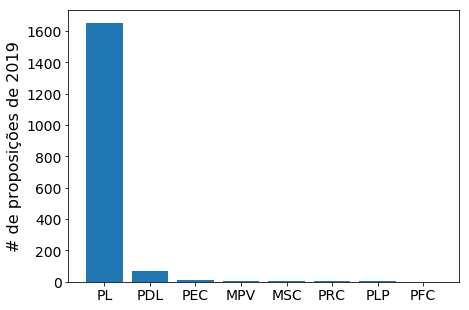

In [17]:
pl.figure(figsize=(7,5))
#pl.title('2019')
nByTipo = s.loc[(s.ano>=2019)&(s.ano<=2019)].groupby('siglaTipo').size().sort_values(ascending=False)
x = np.arange(1,1+len(nByTipo))
pl.xticks(x,nByTipo.index.values)
pl.bar(x,nByTipo.values)
pl.gca().tick_params(labelsize=14)
pl.ylabel(u'# de proposições de 2019', fontsize=16)
#xu.saveFigWdate('graficos/proposicoes-2019-por-tipo.pdf')
pl.show()

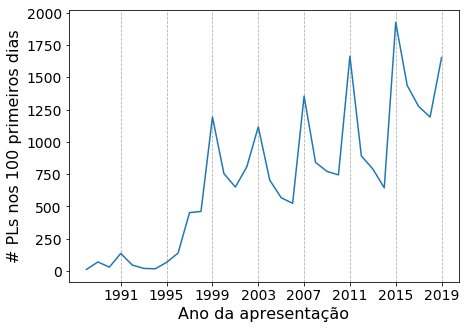

In [60]:
pl.figure(figsize=(7,5))
pl.plot(s.loc[(s.siglaTipo=='PL') & 
              (temasData.dataDisplaced>='2019-02-01') & 
              (temasData.dataDisplaced<'2019-05-12')].groupby('ano')['id'].size())
pl.xticks(np.arange(2019,1990,-4))
pl.grid(axis='x', linestyle='--')
pl.gca().tick_params(labelsize=14)
pl.xlabel(u'Ano da apresentação', fontsize=16)
pl.ylabel(u'# PLs nos 100 primeiros dias', fontsize=16)
#xu.saveFigWdate('graficos/PLs-por-ano.pdf')
pl.show()

### Frequência dos temas para PLs

In [19]:
xu.columns(s)

13: ano | anoProp | api_url | capture_date | codTema | dataApresentacao | dataDisplaced | id | numero | relevancia | siglaTipo | tema | uriProposicao


In [22]:
print(s[['ano', 'tema', 'siglaTipo', 'numero', 'uriProposicao']]['uriProposicao'][0])

https://dadosabertos.camara.leg.br/api/v2/proposicoes/14250


In [36]:
# Calcula total de proposições em cada ano:
nPLTotalByAno      = s.loc[(s.siglaTipo=='PL')].groupby('ano').size()
nPLTotalByAno.name = 'ntotal'

In [37]:
# Calcula número de proposições de cada tema, por ano:
nPLByAnoTema      = s.loc[(s.siglaTipo=='PL')].groupby(['ano','tema']).size()
nPLByAnoTema.name = 'counts'
nPLByAnoTema      = nPLByAnoTema.reset_index()

# Junta as duas informações acima:
nPLByAnoTema = nPLByAnoTema.join(nPLTotalByAno, on='ano', how='outer')

In [38]:
# Calcula fração das proposições em cada tema, por ano:
nPLByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nPLByAnoTema.counts))
nPLByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nPLByAnoTema.ntotal))
nPLByAnoTema['frac']    = nPLByAnoTema.counts/nPLByAnoTema.ntotal
nPLByAnoTema['fracErr'] = np.sqrt(nPLByAnoTema.counts/nPLByAnoTema.ntotal**2 - \
                                  nPLByAnoTema.counts**2/nPLByAnoTema.ntotal**3)

In [39]:
listaTemasPL = np.array(sorted(r.tema.unique()))

In [40]:
mFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
#mFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2015]))].groupby('tema')['frac'].mean()
#sFracPL = nPLByAnoTema.loc[(nPLByAnoTema.ano.isin([2011,2015]))].groupby('tema')['frac'].std()
mFracPL.name = 'fracMean'
sFracPL.name = 'fracDev'
changeBasePL = nPLByAnoTema.loc[nPLByAnoTema.ano==2019].join(mFracPL,on='tema').join(sFracPL,on='tema')
changeBasePL['dfrac'] = changeBasePL['frac']-changeBasePL['fracMean']
changeBasePL = changeBasePL.sort_values('frac')

In [41]:
(changeBasePL.set_index('tema')['dfrac']/changeBasePL.set_index('tema')['fracDev']).sort_values(ascending=False)

tema
Administração Pública                          2.838577
Meio Ambiente e Desenvolvimento Sustentável    2.684309
Direito Constitucional                         2.591988
Direito Penal e Processual Penal               2.015463
Economia                                       1.753157
Viação, Transporte e Mobilidade                1.014337
Arte, Cultura e Religião                       0.866738
Direitos Humanos e Minorias                    0.841292
Energia, Recursos Hídricos e Minerais          0.744707
Defesa e Segurança                             0.410934
Indústria, Comércio e Serviços                 0.276402
Direito e Justiça                              0.205517
Política, Partidos e Eleições                 -0.157420
Estrutura Fundiária                           -0.208901
Educação                                      -0.225093
Previdência e Assistência Social              -0.243745
Ciência, Tecnologia e Inovação                -0.284352
Saúde                                      

In [51]:
# Tabela para a Elaine. Note que a seleção de 's' acima foi a seguinte:
# s = temasData.loc[(temasData.dataDisplaced>='2019-02-01') & (temasData.dataDisplaced<='2019-05-11')]
nPLs_tema_vs_ano = pd.pivot_table(nPLByAnoTema[nPLByAnoTema['ano'].isin([1999,2003,2007,2011,2015,2019])],
                                  values='counts', index='tema', columns='ano')
nPLs_tema_vs_ano.to_excel('../relatorios/tab_toElaine_nPLs_por_tema_e_ano_100dias.xlsx')

In [42]:
fracColorPL = [fracColorF(x,m,z) for x,m,z in zip(changeBasePL['frac'],changeBasePL['fracMean'],changeBasePL['fracDev'])]

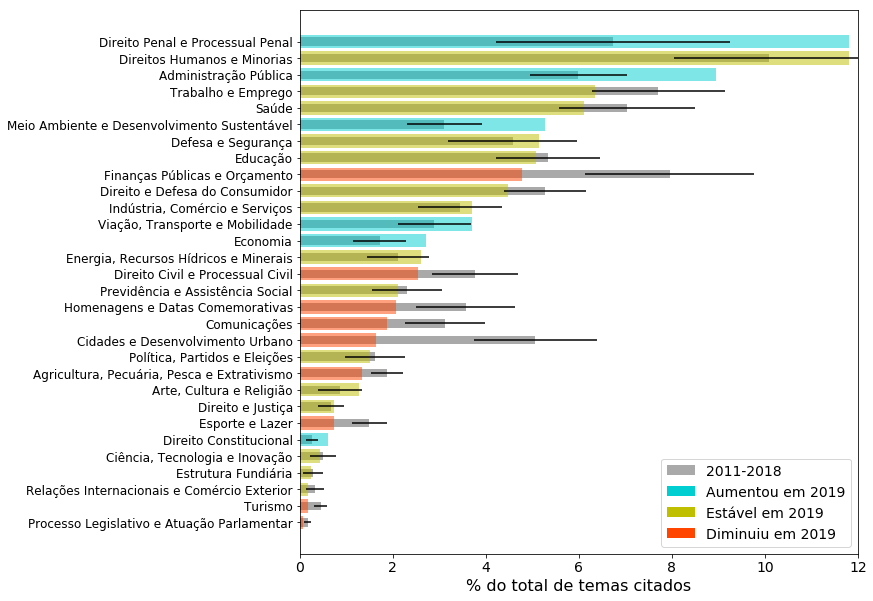

In [43]:
# Gráfico completo:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

pl.barh(x,100*np.nan_to_num(changeBasePL.fracMean.values), 
        xerr=100*np.nan_to_num(changeBasePL.fracDev.values), height=0.5, color='darkgray')
pl.barh(x,100*changeBasePL.frac.values, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')

pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
#xu.saveFigWdate('graficos/temas_PL_fracao2019-vs-mediaAnterior.pdf')
pl.show()

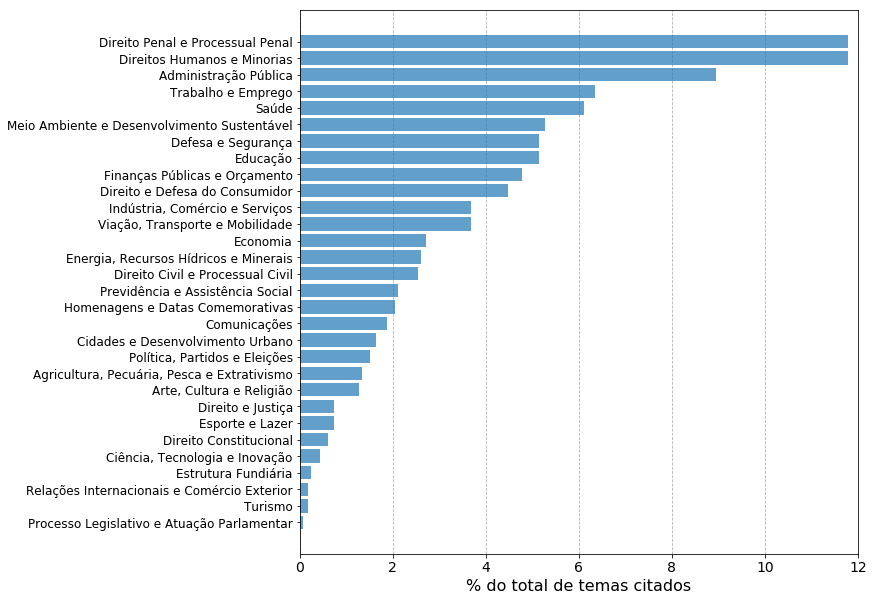

In [192]:
# Gráfico só de 2019:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBasePL))

pl.barh(x,100*changeBasePL.frac.values, zorder=2, alpha=0.7)
#pl.barh(x,100*changeBasePL.fracMean.values, height=0.5, color='darkgray')
#pl.barh(x,100*changeBasePL.frac.values, zorder=2, color=fracColorPL, alpha=0.5)
pl.yticks(x,changeBasePL.tema.values)
pl.gca().tick_params(axis='y', labelsize=12)
pl.gca().tick_params(axis='x', labelsize=14)

pl.xlim([0,12])
pl.xlabel(u'% do total de temas citados', fontsize=16)
pl.grid(axis='x', zorder=0, linestyle='--')
#xu.saveFigWdate('graficos/temas_PL_fracao2019.pdf')
pl.show()

## Frequência de temas para recortes não usados

#### Para a seleção feita (dataframe 's')

In [100]:
# Calcula total de proposições em cada ano:
nSTotalByAno      = s.groupby('ano').size()
nSTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nSByAnoTema      = s.groupby(['ano','tema']).size()
nSByAnoTema.name = 'counts'
nSByAnoTema      = nSByAnoTema.reset_index()

# Junta as duas informações acima:
nSByAnoTema = nSByAnoTema.join(nSTotalByAno, on='ano', how='outer')

In [101]:
# Calcula fração das proposições em cada tema, por ano:
nSByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nSByAnoTema.counts))
nSByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nSByAnoTema.ntotal))
nSByAnoTema['frac']    = nSByAnoTema.counts/nSByAnoTema.ntotal
nSByAnoTema['fracErr'] = np.sqrt(nSByAnoTema.counts/nSByAnoTema.ntotal**2 - nSByAnoTema.counts**2/nSByAnoTema.ntotal**3)

In [102]:
listaTemasS = np.array(sorted(s.tema.unique()))

In [75]:
mFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFracS = nSByAnoTema.loc[(nSByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFracS.name = 'fracMean'
sFracS.name = 'fracDev'
changeBaseS = nSByAnoTema.loc[nSByAnoTema.ano==2019].join(mFracS,on='tema').join(sFracS,on='tema')
changeBaseS['dfrac'] = changeBaseS['frac']-changeBaseS['fracMean']
changeBaseS = changeBaseS.sort_values('frac')

In [76]:
fracColorS = [fracColorF(x,m,s) for x,m,s in zip(changeBaseS['frac'],changeBaseS['fracMean'],changeBaseS['fracDev'])]

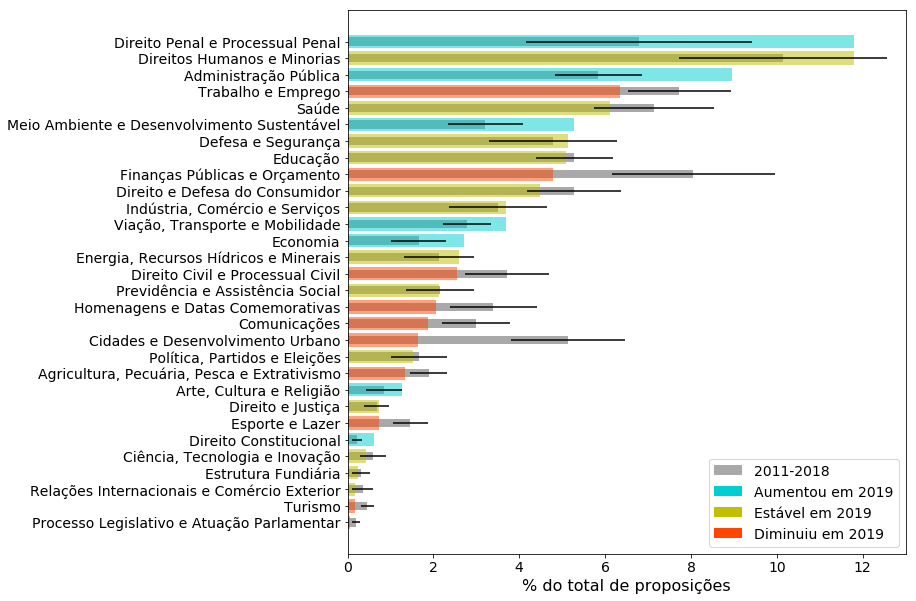

In [77]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBaseS))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBaseS.fracMean.values, xerr=100*changeBaseS.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBaseS.frac.values, color=fracColorS, alpha=0.5)
pl.yticks(x,changeBaseS.tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim([0,13])
pl.xlabel(u'% do total de proposições', fontsize=16)
#xu.saveFigWdate('graficos/temas_PL100dias_fracao2019-vs-mediaAnterior.pdf')
pl.show()

#### Para a base completa

##### Preparo de base de dados de contagem

In [5]:
# Calcula total de proposições em cada ano:
nTotalByAno      = r.groupby('ano').size()
nTotalByAno.name = 'ntotal'

# Calcula número de proposições de cada tema, por ano:
nByAnoTema      = r.groupby(['ano','tema']).size()
nByAnoTema.name = 'counts'
nByAnoTema      = nByAnoTema.reset_index()

# Junta as duas informações acima:
nByAnoTema = nByAnoTema.join(nTotalByAno, on='ano', how='outer')

In [6]:
xu.checkMissing(nByAnoTema)

Colunas com valores faltantes:
Empty DataFrame
Columns: [coluna, N, %]
Index: []


In [7]:
# Calcula fração das proposições em cada tema, por ano:
nByAnoTema['poissonCounts'] = pd.Series(np.sqrt(nByAnoTema.counts))
nByAnoTema['poissonTotal']  = pd.Series(np.sqrt(nByAnoTema.ntotal))
nByAnoTema['frac']    = nByAnoTema.counts/nByAnoTema.ntotal
nByAnoTema['fracErr'] = np.sqrt(nByAnoTema.counts/nByAnoTema.ntotal**2 - nByAnoTema.counts**2/nByAnoTema.ntotal**3)

In [8]:
listaTemas = np.array(sorted(r.tema.unique()))

In [ ]:
# SÉRIES INTERESSANTES:
# i=1, agricultura, salto em 2011;
# i=3, cidades e desenvolvimento urbano, crescimento a partir de 2005, 2019 bem baixo.
# i=5, comunicações, pico de 2002 a 2010, queda em 2019.
# i=6, defesa e segurança, crescimento lento e constate, com pico em 2019.
# i=7, direito civil, queda de 1997 a 2007, depois estável até 2015, ligeiro aumento, 2019 estável, pouco interessante.
# i=8, direito constituicional, pico em 2018 e 2019.
# i=9, direito penal, U de 2001 a 2018, pico bem alto em 2019.
# i=10, direito do consumidor, surto em 2011 e crescimento desde então.
# i=11, direito e justiça, surto em 2011 e crescimento desde então (mas menos que acima).
# i=12, direitos humanos e minorias, crescimento a partir de 2011, com pico em 2019.
# i=15, recursos hídricos e minerais, leve crescimento desde 2003.
# i=17, estrutura fundiária, queda em 2011, podemos relacionar com agricultura.
# i=18, finanças públicas e orçamento, U de 1999 a 2002, platô posterior, pouco interessante.
# i=19, homenagens e datas comemorativas, crescimento constante desde 2002.
# i=21, meio ambiente e desenv. sust., pico em 2019.
# i=22, políticos, partidos e eleições, platô desde 2011.
# i=25, relações internacionais, crescimento de 2001 a 2006, estável até 2018, queda abrupta em 2019.
# i=26, saúde, crescimento desde 1987, queda em 2019.
# i=27, trabalho e empredo, queda de 1987 a 2003, estável desde então, ligeiro aumento em 2019.


##### Média e desvio padrão de 2011 a 2018

In [9]:
mFrac = nByAnoTema.loc[(nByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].mean()
sFrac = nByAnoTema.loc[(nByAnoTema.ano.isin([2011,2012,2013,2014,2015,2016,2017,2018]))].groupby('tema')['frac'].std()
mFrac.name = 'fracMean'
sFrac.name = 'fracDev'
changeBase = nByAnoTema.loc[nByAnoTema.ano==2019].join(mFrac,on='tema').join(sFrac,on='tema')
changeBase['dfrac'] = changeBase['frac']-changeBase['fracMean']
changeBase = changeBase.sort_values('frac')

In [10]:
fracColor = [fracColorF(x,m,s) for x,m,s in zip(changeBase['frac'],changeBase['fracMean'],changeBase['fracDev'])]

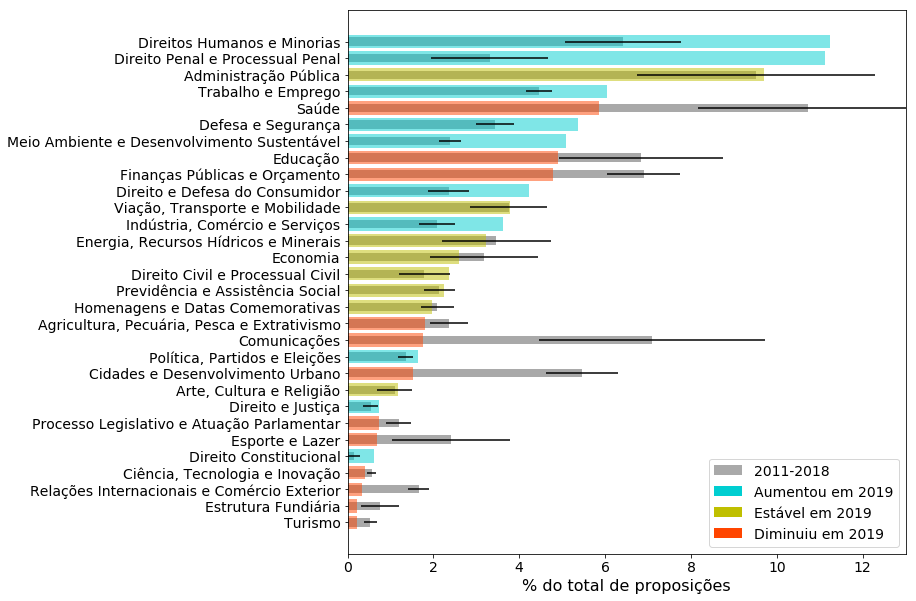

In [20]:
from matplotlib.patches import Patch

pl.figure(figsize=(10,10))
x = np.arange(1,1+len(changeBase))

#pl.subplot(1,2,1)
pl.barh(x,100*changeBase.fracMean.values, xerr=100*changeBase.fracDev.values, height=0.5, color='darkgray')
pl.barh(x,100*changeBase.frac.values, color=fracColor, alpha=0.5)
pl.yticks(x,changeBase.tema.values)
pl.gca().tick_params(labelsize=14)

#pl.subplot(1,2,2)
#pl.barh(x,100*changeBase.dfrac.values, xerr=100*changeBase.fracDev.values)
#pl.yticks(x,changeBase.tema.values)
#pl.gca().tick_params(labelsize=14, labelleft=False, labelright=True)

#pl.subplots_adjust(wspace=0)

# Legenda:
legend_elements = [Patch(facecolor='darkgray', label='2011-2018'),
                   Patch(facecolor='darkturquoise', label='Aumentou em 2019'),
                   Patch(facecolor='y',     label=u'Estável em 2019'),
                   Patch(facecolor='orangered',label='Diminuiu em 2019'),]
pl.legend(handles=legend_elements, fontsize=14, loc='lower right')


pl.xlim([0,13])
pl.xlabel(u'% do total de proposições', fontsize=16)
#xu.saveFigWdate('graficos/temas_proposicoes_fracao2019-vs-mediaAnterior.pdf')
pl.show()

## Gráficos de tendências históricas

#### Definição de funções

In [193]:
# Plotting function:
def trendPlot(x,y,yerr,coefs,cov,title):
    anoStart = 1999
    anoEnd   = 2019

    if len(coefs)==3:
        ypred = coefs[0]*x**2 + coefs[1]*x + coefs[2]
    elif len(coefs)==2:
        ypred = coefs[0]*x+coefs[1]
    elif len(coefs)==1:
        ypred = coefs[0]*np.ones(len(x))
    else:
        print 'ERROR! Requested polynomial degree not implemented.'
        return 0
    
    from matplotlib import gridspec
    pl.figure(figsize=(7.4,5.5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

    # Plot full:
    pl.subplot(gs[0])
    # Título:
    pl.title(title, fontsize=16)
    # Texto:
    if len(coefs)==3:
        pl.text(0.95,0.95, 
                'Coef: {:.2e} +/- {:.2e}\n          {:.2e} +/- {:.2e}\n'.format(coefs[0],np.sqrt(cov[0][0]),
                                                                                 coefs[1],np.sqrt(cov[1][1])),
                transform = pl.gca().transAxes, fontsize=14, horizontalalignment='right', #backgroundcolor='white',
                verticalalignment='top')
    elif len(coefs)==2:
        pl.text(0.9,0.95, 'Coef: {:.2e} +/- {:.2e}'.format(coefs[0],np.sqrt(cov[0][0])),
                transform = pl.gca().transAxes, fontsize=14, horizontalalignment='right', #backgroundcolor='white',
                verticalalignment='top')
    # Plot mesmo:
    pl.errorbar(x, y, yerr=yerr, fmt='r-', label=u'Observado')
    pl.plot(x, ypred, 'b-', label=u'Ajuste até 2018')
    # Formatação:
    pl.xticks(np.arange(1987,2020,4))
    pl.grid(axis='x')
    # Eixo:
    pl.ylabel(u'% dos PLs', fontsize=16)
    pl.gca().tick_params(labelbottom=False)
    pl.xlim([anoStart-1,anoEnd+1])
    pl.gca().tick_params(labelsize=14)
    # Legenda:
    pl.legend(loc='upper left', fontsize=14)

    # Plot resíduos:
    pl.subplot(gs[1])
    pl.errorbar(x, (y-ypred), yerr=yerr, fmt='r-')
    pl.axhline(0,color='blue')
    # Formatação
    pl.xticks(np.arange(1987,2020,4))
    pl.grid(axis='x')
    pl.gca().tick_params(labelsize=14)
    # Eixo:
    pl.ylabel(u'Resíduos', fontsize=16)
    pl.xlabel('Ano', fontsize=16)
    pl.xlim([anoStart-1,anoEnd+1])

    pl.subplots_adjust(hspace=0.05)

In [194]:
# Ajuste linear:
def fitPoly(i, degree):
    baseTema = nPLByAnoTema
    anoStart = 1999
    anoEnd   = 2019
    x    =     baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['ano'].values
    y    = 100*baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['frac'].values
    yerr = 100*baseTema.loc[(baseTema.ano>=anoStart) & (baseTema.tema==listaTemasPL[i])]['fracErr'].values
    coefs, cov = np.polyfit(x[:-1],y[:-1],degree,w=1.0/yerr[:-1], cov=True)
    if degree==2:
        ypred = coefs[0]*x**2 + coefs[1]*x + coefs[2]
    elif degree==1:
        ypred = coefs[0]*x+coefs[1]
    elif degree==0:
        ypred = coefs[0]*np.ones(len(x))
    else:
        print 'ERROR! Requested polynomial degree not implemented.'
        return 0
    return x,y,yerr,coefs,cov,ypred


def fitNplot(i, degree):
    x,y,yerr,coefs,cov,ypred = fitPoly(i, degree)
    trendPlot(x,y,yerr,coefs,cov,listaTemasPL[i])

In [195]:
import scipy as sc
def Ftest(i, d2, d1):
    """ Output p-value for F given by dof d2+1 and d1+1 (d1 and d2 are polynomial degree) and data from ith tema """
    result1 = fitPoly(i, d1)
    result2 = fitPoly(i, d2)
    rss1    = np.sum((result1[1][:-1]-result1[5][:-1])**2/result1[2][:-1]**2)
    rss2    = np.sum((result2[1][:-1]-result2[5][:-1])**2/result2[2][:-1]**2)
    n       = len(result1[0][:-1])
    F = (rss1-rss2)/(d2-d1)/(rss2/(n-d2-1))
    return 1.0 - sc.stats.f.cdf(F,d2+1,d1+1)

def defDegree(i):
    alphaVal = 0.05
    if Ftest(i,2,1)<alphaVal:
        return 2
    if Ftest(i,1,0)<alphaVal:
        return 1
    else:
        return 0

#### Gráficos interessantes

In [114]:
i = 3
print Ftest(i,2,1), Ftest(i,1,0)

AttributeError: 'module' object has no attribute 'stats'

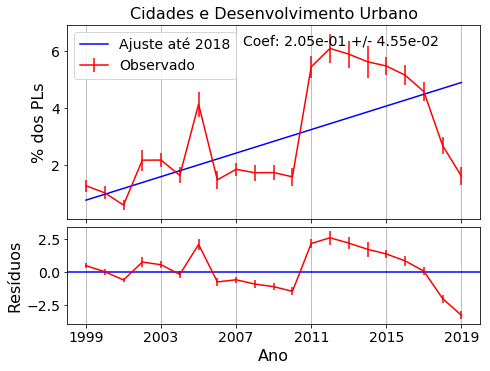

In [196]:
fitNplot(3,1)

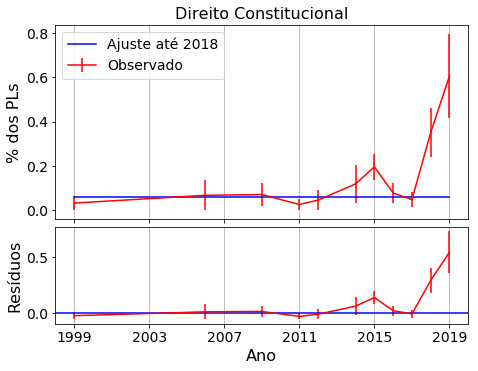

In [197]:
fitNplot(8,0)

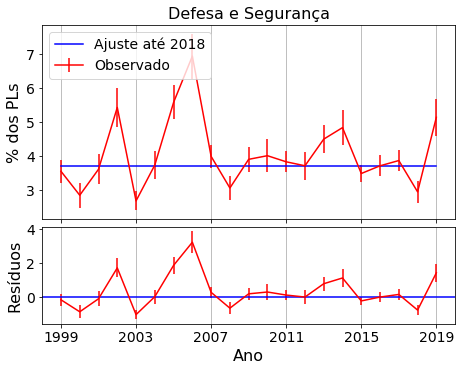

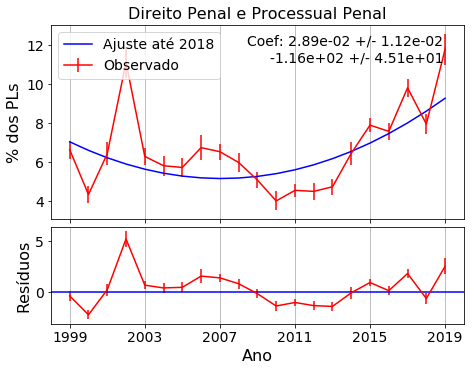

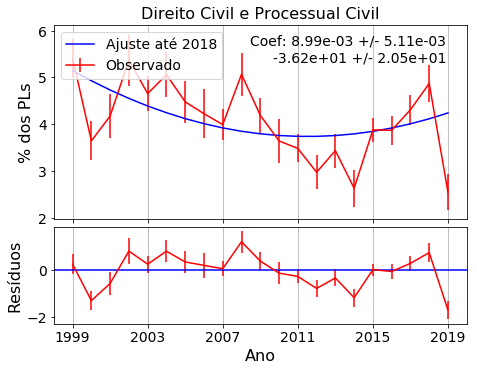

In [198]:
fitNplot(6,0)
fitNplot(9,2)
fitNplot(7,2)

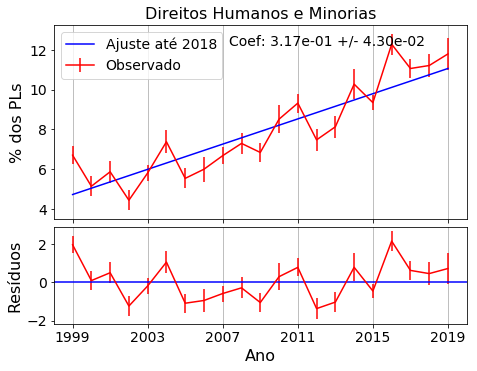

In [199]:
fitNplot(12,1)
#xu.saveFigWdate('graficos/PL-direitos-humanos-por-ano.pdf')

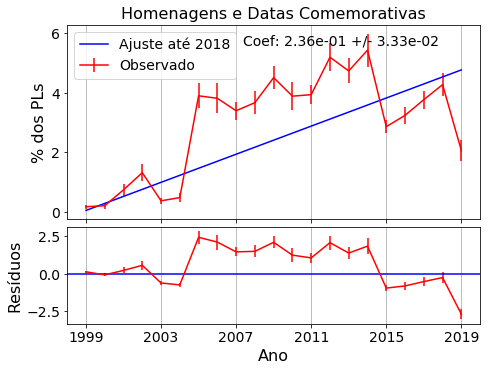

In [200]:
fitNplot(19,1)

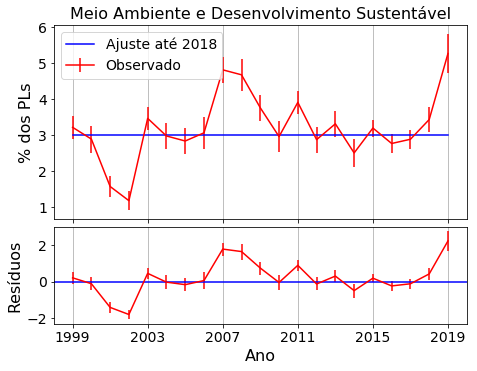

In [201]:
fitNplot(21,0)

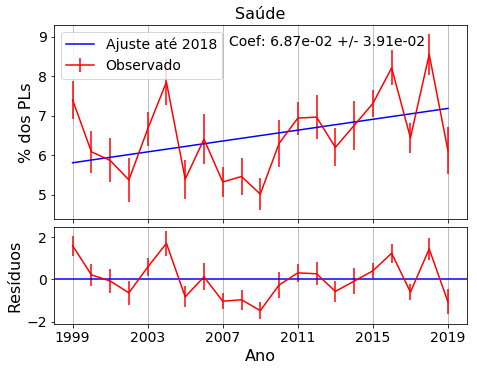

In [202]:
fitNplot(26,1)

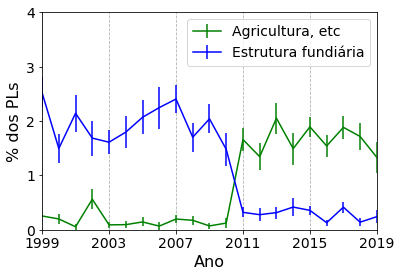

In [203]:
# Plot:
baseTema  = nPLByAnoTema
nByAno = baseTema.loc[baseTema.tema==listaTemasPL[1]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='g-', 
            label='Agricultura, etc')
nByAno = baseTema.loc[baseTema.tema==listaTemasPL[17]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='b-', 
            label=u'Estrutura fundiária')
#nByAno = nByAnoTema.loc[nByAnoTema.tema==listaTemas[17]]
#pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='b-', 
#            label=u'Estrutura fundiária')
# Formatação
pl.xticks(np.arange(1987,2020,4))
pl.grid(axis='x',linestyle='--')
pl.xlabel('Ano', fontsize=16)
pl.ylabel(u'% dos PLs', fontsize=16)
pl.ylim([0,4])
pl.xlim([1999,2019])
# Legenda:
pl.legend(loc='upper right', fontsize=14)
pl.gca().tick_params(labelsize=14)
#xu.saveFigWdate('graficos/PL-agricultura-por-ano.pdf')
pl.show()

#### Gráficos não tão interessantes

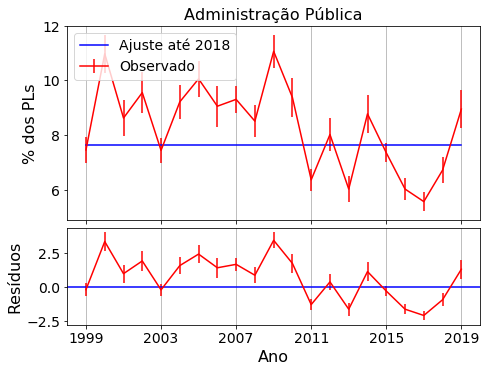

In [204]:
fitNplot(0,0)

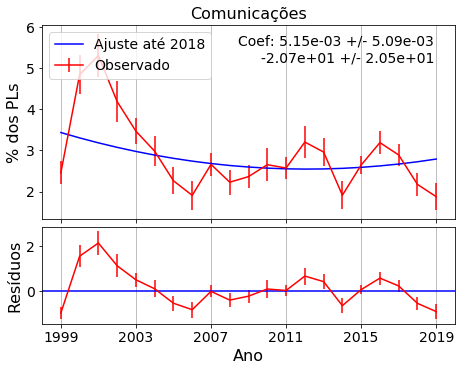

In [205]:
fitNplot(5,2)

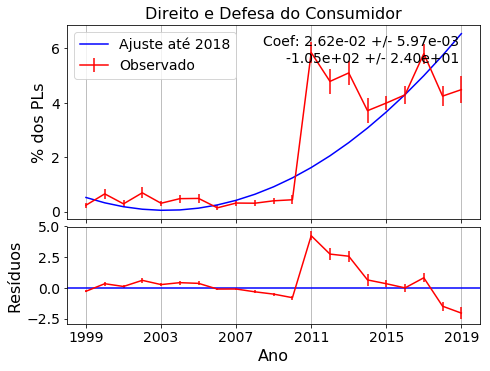

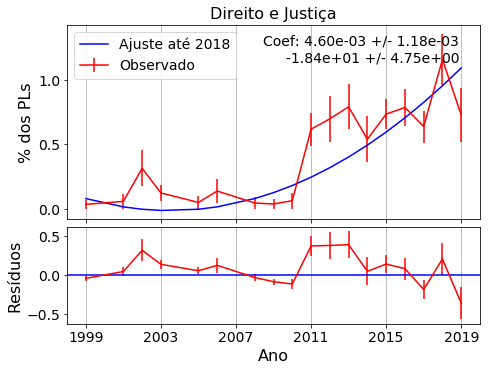

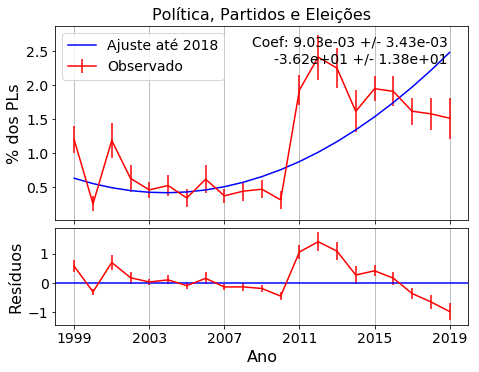

In [206]:
fitNplot(10,2)
fitNplot(11,2)
fitNplot(22,2)

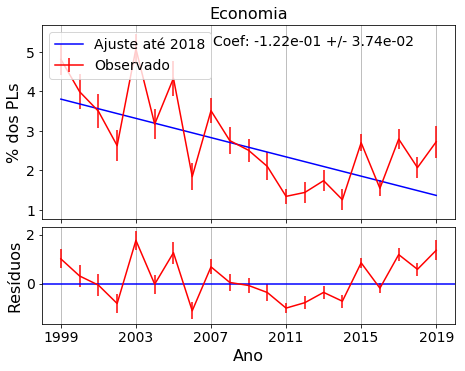

In [207]:
fitNplot(13,1)

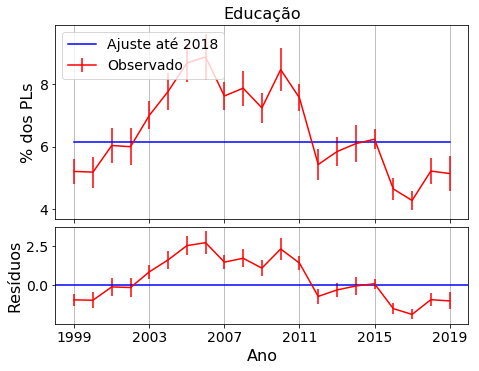

In [208]:
fitNplot(14,0)

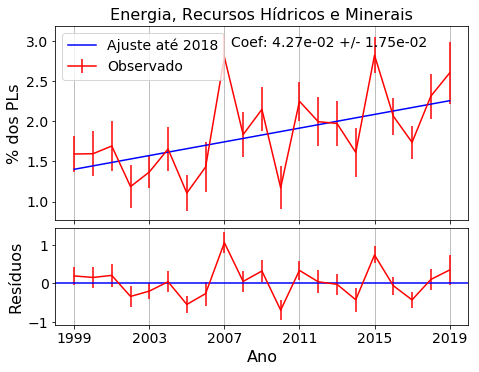

In [209]:
fitNplot(15,1)

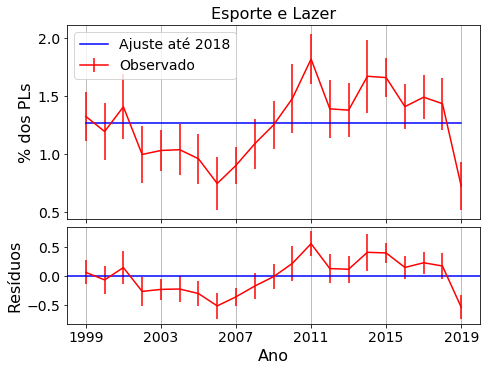

In [210]:
fitNplot(16,0)

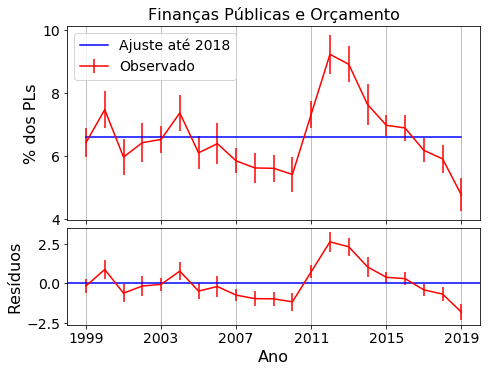

In [211]:
fitNplot(18,0)

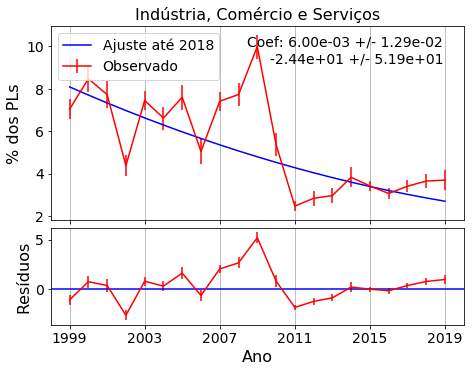

In [212]:
fitNplot(20,2)

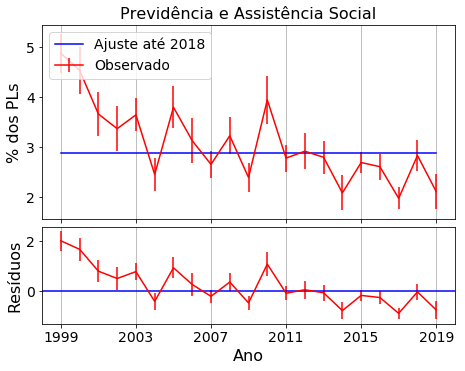

In [213]:
fitNplot(23,0)

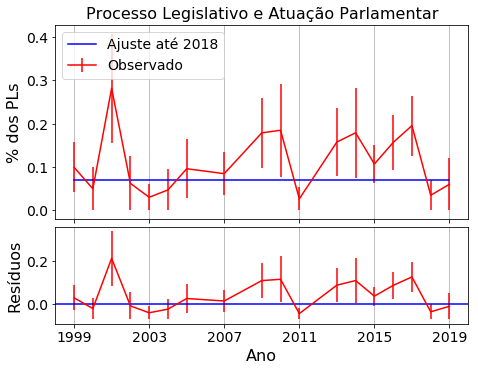

In [214]:
fitNplot(24,0)

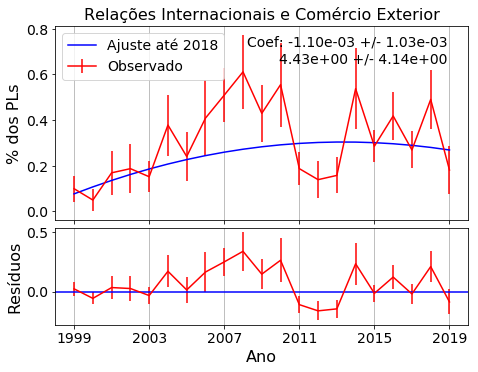

In [215]:
fitNplot(25,2)

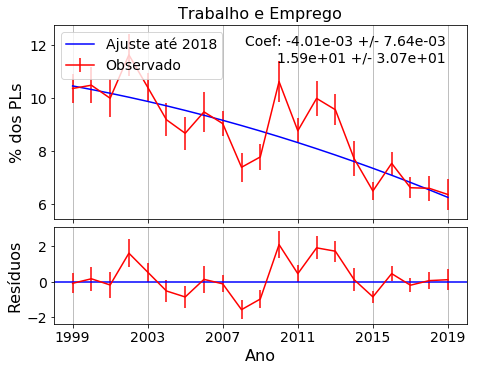

In [216]:
fitNplot(27,2)

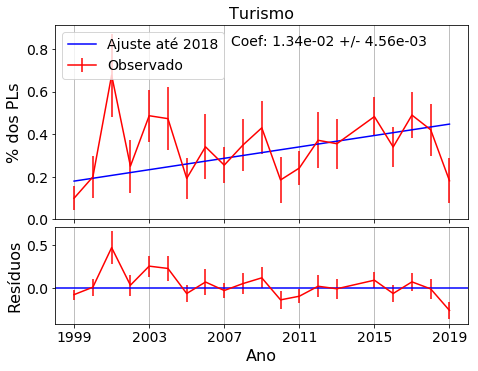

In [217]:
fitNplot(28,1)

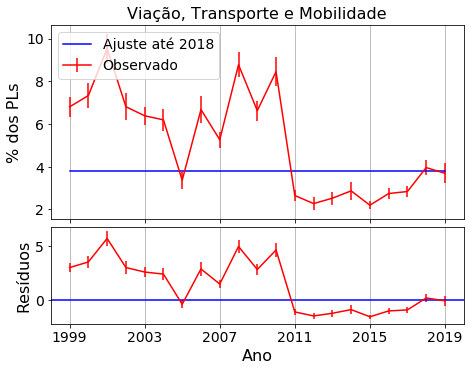

In [218]:
fitNplot(29,0)

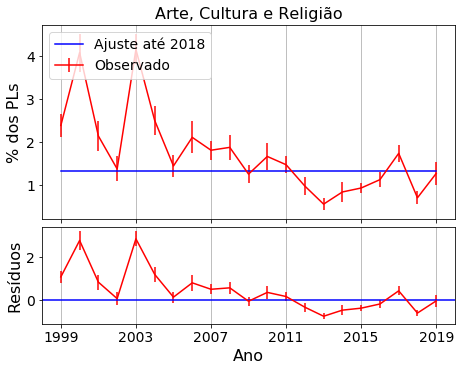

In [219]:
fitNplot(2,0)

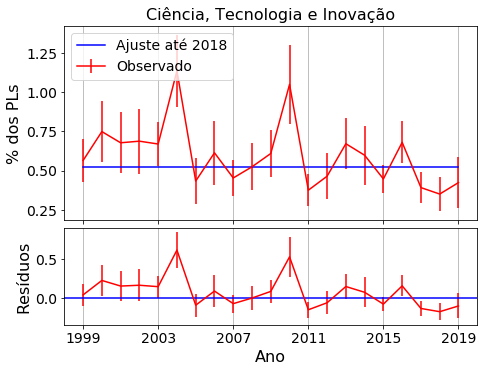

In [220]:
fitNplot(4,0)

# Testes 

In [59]:
# Vemos que não existem linhas duplicadas mas existem uma proposição que aparece mais de uma vez:
print len(r), len(r.drop_duplicates()), len(r.id.unique())

135668 135668 113973


In [57]:
# Verificamos que uma proposição pode aparecer mais de uma vez com temas diferentes:
r.groupby('id').nunique()

,ano,api_url,capture_date,codTema,numero,relevancia,siglaTipo,tema,uriProposicao,id
id,,,,,,,,,,
13140,1,0,0,2,1,1,1,2,1,1
13192,1,0,0,2,1,1,1,2,1,1
13338,1,0,0,2,1,1,1,2,1,1
13491,1,0,0,1,1,1,1,1,1,1
13496,1,0,0,1,1,1,1,1,1,1
13512,1,0,0,1,1,1,1,1,1,1
13525,1,0,0,2,1,1,1,2,1,1
13590,1,0,0,2,1,1,1,2,1,1
13592,1,0,0,1,1,1,1,1,1,1


# Lixo

In [ ]:
# Evolução da fração de proposições com aquele tema:
i=6
nByAno = nByAnoTema.loc[nByAnoTema.tema==listaTemas[i]]
pl.errorbar(nByAno.ano.values, 100*nByAno.frac.values, yerr=100*nByAno.fracErr, fmt='r-')
pl.title(listaTemas[i])
pl.xticks(np.arange(1987,2020,4))
pl.grid(axis='x')
pl.xlabel('Ano')
pl.ylabel(u'% das proposições')
#pl.ylim([0,10])
pl.show()

In [ ]:
# Decomposição sazonal, não funciona:
from statsmodels.tsa.seasonal import seasonal_decompose
i=6
temporal = nByAnoTema.loc[(nByAnoTema.ano>=1999) & (nByAnoTema.tema==listaTemas[i])].set_index('ano')['frac']
temporal.index = pd.to_datetime(temporal.index, format='%Y')
result = seasonal_decompose(temporal, model='additive')
result.plot()
pl.show()